<a href="https://colab.research.google.com/github/marandnie/Mate3/blob/main/Tp_final_mate3_Nieto_Marina_Andrea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP Final
###Materia: Matemática 3
###Estudiante: Nieto, Marina Andrea
En este trabajo práctico, vamos a analizar la duración de los viajes del sistema de bicicletas público "Ecobici" realizados en el año 2019. Los datos corresponden a 1(un) viaje realizado, con una estación de origen de dónde se retira la bicicleta y una estación de destino dónde se entrega la bicicleta al finalizar. Está diferenciado por género de usuario y contiene también información sobre la duración del viaje y la fecha y hora de origen. Teniendo en cuenta estas dos últimas variables, de descartó la columna de fecha y hora de destino por ser redundante.

El dataset contenía más datos en un principio. Se realizó un recorte en la cantidad de columnas tomadas en consideración.
A su vez, se realizó el analisis solamente sobre la estación Nro 175, ex Esmeralda y Corrientes (que resultó ser la más numerosa en viajes).

Consideraciones: El género (genero_usuario), la estación de origen(id_estacion_origen), la estación de destino(id_estacion_destino) y la fecha y hora de origen(fecha_origen_recorrido) fueron consideradas las variables independientes. La duración del recorrido(duracion_recorrido) fue considerada la variable dependiente.

Con la hora de origen, se creo una nueva columna llamada franja horaria. Se agruparon como: Mañana, tarde, noche y madrugada.

Se realizó una regresión lineal múltiple sobre los datos.

Debido a que todas las variables independientes son categóricas, no se pudo realizar un scatter plot en el analisis de los datos sobre la regresión.

Cómo hipótesis podemos plantear que los viajes realizados a la tarde van a tener una mayor duración en promedio, debido a que si se retira la bicicleta en ese horario, se tratará de un viaje más ocioso.


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

In [ ]:
cols = [
    "genero_usuario",
    "id_estacion_origen",
    "id_estacion_destino",
    "fecha_origen_recorrido",
    "duracion_recorrido"
]

dataset = pd.read_csv("/content/drive/MyDrive/UNSAM/TPI/Mate 3/tp_final.csv", usecols=cols)
# solo viajes que partan desde la estación de Av Corrientes y Esmeralda (nro 175) 
dataset = dataset.dropna(subset=[col for col in cols if col != "genero_usuario"])

# pasamos a int por si hay discrepancias en el tipo de la columna
dataset["id_estacion_destino"] = dataset["id_estacion_destino"].astype(int) 
dataset["id_estacion_origen"] = dataset["id_estacion_origen"].astype(int) 
dataset = dataset[dataset.id_estacion_origen == 175]

# pasar a "NO INFORMADO" los not a numbers de genero 
dataset.loc[dataset["genero_usuario"].isna(), "genero_usuario"] = 'NO INFORMADO'
# dropear las filas con huecos en las demás variables (categóricas más delicadas de rellenar)
# no hace falta el imputer (no sirve llenar con "modas" las estaciones o duraciones)

dataset.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(77136, 5)

In [ ]:
# para que tome las ids como categoricas
dataset.astype({"id_estacion_destino": "category", "id_estacion_origen": "category"}).describe(include="all")

,genero_usuario,fecha_origen_recorrido,id_estacion_origen,duracion_recorrido,id_estacion_destino
count,77136,77136,77136,77136,77136
unique,3,69435,1,7311,395
top,NO INFORMADO,2019-11-28 18:33:00,175,0 days 00:00:02.000000000,175
freq,76369,10,77136,394,4363


In [ ]:
dataset

,genero_usuario,fecha_origen_recorrido,id_estacion_origen,duracion_recorrido,id_estacion_destino
567,F,2019-01-01 19:06:39,175,0 days 00:12:48.000000000,93
935,M,2019-01-02 02:53:17,175,0 days 00:10:58.000000000,95
1381,M,2019-01-02 08:57:45,175,0 days 00:02:24.000000000,23
1965,M,2019-01-02 12:47:22,175,0 days 00:08:40.000000000,39
2900,M,2019-01-02 18:50:17,175,0 days 00:06:18.000000000,191
...,...,...,...,...,...
6363833,NO INFORMADO,2019-11-14 17:45:00,175,0 days 00:34:23.000000000,283
6363834,NO INFORMADO,2019-11-19 17:38:00,175,0 days 00:29:44.000000000,283
6363835,NO INFORMADO,2019-11-20 18:54:00,175,0 days 00:31:56.000000000,283
6363836,NO INFORMADO,2019-11-27 19:00:00,175,0 days 00:32:37.000000000,283


In [ ]:
def minutos_de_tiempo(row):
  s = re.split("\s|:", row)  
  return int(s[2])*60 + int(s[3])

dataset["duracion_minutos"] = dataset.duracion_recorrido.apply(minutos_de_tiempo)
dataset

,genero_usuario,fecha_origen_recorrido,id_estacion_origen,duracion_recorrido,id_estacion_destino,duracion_minutos
567,F,2019-01-01 19:06:39,175,0 days 00:12:48.000000000,93,12
935,M,2019-01-02 02:53:17,175,0 days 00:10:58.000000000,95,10
1381,M,2019-01-02 08:57:45,175,0 days 00:02:24.000000000,23,2
1965,M,2019-01-02 12:47:22,175,0 days 00:08:40.000000000,39,8
2900,M,2019-01-02 18:50:17,175,0 days 00:06:18.000000000,191,6
...,...,...,...,...,...,...
6363833,NO INFORMADO,2019-11-14 17:45:00,175,0 days 00:34:23.000000000,283,34
6363834,NO INFORMADO,2019-11-19 17:38:00,175,0 days 00:29:44.000000000,283,29
6363835,NO INFORMADO,2019-11-20 18:54:00,175,0 days 00:31:56.000000000,283,31
6363836,NO INFORMADO,2019-11-27 19:00:00,175,0 days 00:32:37.000000000,283,32


In [ ]:
dataset.duracion_minutos.describe()

count    77136.000000
mean        30.253643
std         60.055782
min          0.000000
25%         11.000000
50%         18.000000
75%         31.000000
max       1422.000000
Name: duracion_minutos, dtype: float64

In [ ]:
def franja_horaria(row):
  s = re.split("\s|:", row)
  hora_recorrido = int(s[1])
  if 6 <= hora_recorrido <= 12:
    return "mañana"
  elif 12 < hora_recorrido <= 18:
    return "tarde"
  elif 18 < hora_recorrido <= 23:
    return "noche"
  else:
    return "madrugada"

dataset["franja_horaria_recorrido"] = dataset.fecha_origen_recorrido.apply(franja_horaria)
dataset

,genero_usuario,fecha_origen_recorrido,id_estacion_origen,duracion_recorrido,id_estacion_destino,duracion_minutos,franja_horaria_recorrido
567,F,2019-01-01 19:06:39,175,0 days 00:12:48.000000000,93,12,noche
935,M,2019-01-02 02:53:17,175,0 days 00:10:58.000000000,95,10,madrugada
1381,M,2019-01-02 08:57:45,175,0 days 00:02:24.000000000,23,2,mañana
1965,M,2019-01-02 12:47:22,175,0 days 00:08:40.000000000,39,8,mañana
2900,M,2019-01-02 18:50:17,175,0 days 00:06:18.000000000,191,6,tarde
...,...,...,...,...,...,...,...
6363833,NO INFORMADO,2019-11-14 17:45:00,175,0 days 00:34:23.000000000,283,34,tarde
6363834,NO INFORMADO,2019-11-19 17:38:00,175,0 days 00:29:44.000000000,283,29,tarde
6363835,NO INFORMADO,2019-11-20 18:54:00,175,0 days 00:31:56.000000000,283,31,tarde
6363836,NO INFORMADO,2019-11-27 19:00:00,175,0 days 00:32:37.000000000,283,32,noche


In [ ]:

def es_finde(row):
  s = re.split("\s|:", row)
  dia_semana = int(s[0])
  if dia_semana <= hora_recorrido <= 12:
    return dia_semana sabado o domingo

dataset["franja_horaria_recorrido"] = dataset.fecha_origen_recorrido.apply(franja_horaria)
dataset

In [ ]:
dataset["misma_estacion"] = dataset["id_estacion_origen"] == dataset["id_estacion_destino"]
dataset

,genero_usuario,fecha_origen_recorrido,id_estacion_origen,duracion_recorrido,id_estacion_destino,duracion_minutos,franja_horaria_recorrido,misma_estacion
567,F,2019-01-01 19:06:39,175,0 days 00:12:48.000000000,93,12,noche,False
935,M,2019-01-02 02:53:17,175,0 days 00:10:58.000000000,95,10,madrugada,False
1381,M,2019-01-02 08:57:45,175,0 days 00:02:24.000000000,23,2,mañana,False
1965,M,2019-01-02 12:47:22,175,0 days 00:08:40.000000000,39,8,mañana,False
2900,M,2019-01-02 18:50:17,175,0 days 00:06:18.000000000,191,6,tarde,False
...,...,...,...,...,...,...,...,...
6363833,NO INFORMADO,2019-11-14 17:45:00,175,0 days 00:34:23.000000000,283,34,tarde,False
6363834,NO INFORMADO,2019-11-19 17:38:00,175,0 days 00:29:44.000000000,283,29,tarde,False
6363835,NO INFORMADO,2019-11-20 18:54:00,175,0 days 00:31:56.000000000,283,31,tarde,False
6363836,NO INFORMADO,2019-11-27 19:00:00,175,0 days 00:32:37.000000000,283,32,noche,False


In [ ]:
dataset = dataset[["genero_usuario", "id_estacion_destino", "franja_horaria_recorrido", "misma_estacion", "duracion_minutos"]]
dataset

,genero_usuario,id_estacion_destino,franja_horaria_recorrido,misma_estacion,duracion_minutos
567,F,93,noche,False,12
935,M,95,madrugada,False,10
1381,M,23,mañana,False,2
1965,M,39,mañana,False,8
2900,M,191,tarde,False,6
...,...,...,...,...,...
6363833,NO INFORMADO,283,tarde,False,34
6363834,NO INFORMADO,283,tarde,False,29
6363835,NO INFORMADO,283,tarde,False,31
6363836,NO INFORMADO,283,noche,False,32


In [ ]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]
X, y

(        genero_usuario  ...  misma_estacion
 567                  F  ...           False
 935                  M  ...           False
 1381                 M  ...           False
 1965                 M  ...           False
 2900                 M  ...           False
 ...                ...  ...             ...
 6363833   NO INFORMADO  ...           False
 6363834   NO INFORMADO  ...           False
 6363835   NO INFORMADO  ...           False
 6363836   NO INFORMADO  ...           False
 6363837   NO INFORMADO  ...           False
 
 [77136 rows x 4 columns], 567         12
 935         10
 1381         2
 1965         8
 2900         6
           ... 
 6363833     34
 6363834     29
 6363835     31
 6363836     32
 6363837    879
 Name: duracion_minutos, Length: 77136, dtype: int64)

In [ ]:
print(dataset.describe())
print(dataset.shape)

       id_estacion_destino  duracion_minutos
count         77136.000000      77136.000000
mean            142.404908         30.253643
std             110.298194         60.055782
min               1.000000          0.000000
25%              49.000000         11.000000
50%             126.000000         18.000000
75%             191.000000         31.000000
max             449.000000       1422.000000
(77136, 5)


In [ ]:
cat_cols = [
  'genero_usuario',
  'id_estacion_destino',
  'franja_horaria_recorrido',
  'misma_estacion'
]
#transforma la columna en varias columnas con 1s y 0s
onehotencoder = make_column_transformer((OneHotEncoder(), cat_cols), remainder = "passthrough")
X = onehotencoder.fit_transform(X).todense()
X

matrix([[1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 1., ..., 1., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(61708, 404)
(15428, 404)
(61708,)
(15428,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


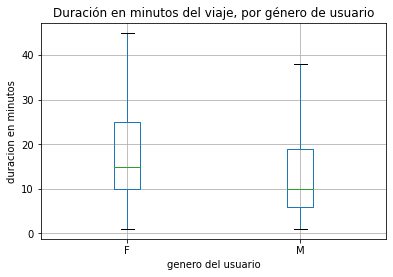

In [ ]:
dataset[dataset.genero_usuario != "NO INFORMADO"].boxplot(column="duracion_minutos", by="genero_usuario", showfliers=False)
plt.title("Duración en minutos del viaje, por género de usuario")
plt.ylabel("duracion en minutos")
plt.xlabel("genero del usuario")
plt.suptitle("")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


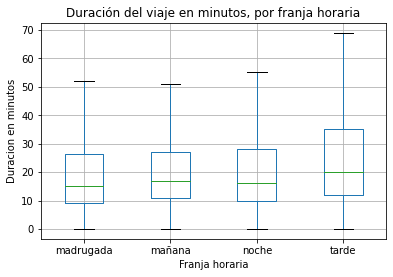

In [ ]:
dataset.boxplot(column="duracion_minutos", by="franja_horaria_recorrido", showfliers=False)
plt.title("Duración del viaje en minutos, por franja horaria")
plt.ylabel("Duracion en minutos")
plt.xlabel("Franja horaria")
plt.suptitle("")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


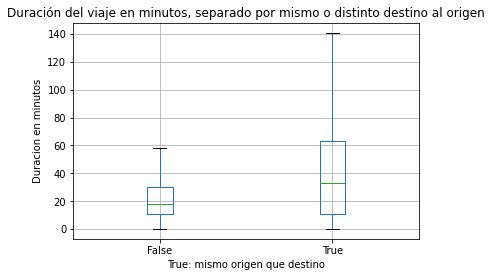

In [ ]:
dataset.boxplot(column="duracion_minutos", by="misma_estacion", showfliers=False)
plt.title("Duración del viaje en minutos, separado por mismo o distinto destino al origen")
plt.ylabel("Duracion en minutos")
plt.xlabel("True: mismo origen que destino")
plt.suptitle("")
plt.show()

In [ ]:
regression = LinearRegression()
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicción': y_pred})
df.sample(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


,Actual,Predicción
1846436,11,20.441406
3979796,17,23.468750
3219210,1,63.591797
3220743,359,65.556641
3175629,15,32.458984
3911140,7,37.677734
3346558,26,43.041016
1906895,23,33.810547
648703,15,23.468750
2277408,8,17.927734


In [ ]:
print('Error Medio Absoluto (MAE):', metrics.mean_absolute_error(y_test, y_pred))  
print('Error cuadrático medio (MSE):', metrics.mean_squared_error(y_test, y_pred, squared=True))  
print('Error cuadrático medio de raíz (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Error Medio Absoluto (MAE): 8115320096.288091
Error cuadrático medio (MSE): 6.378660810564861e+23
Error cuadrático medio de raíz (RMSE): 798665187081.8497


In [ ]:
np.abs(df["Predicción"]).sort_values(ascending=False)[:5]

92736      9.793657e+13
6226448    9.978191e+12
6089325    9.101197e+12
6327674    8.187201e+12
5191029    2.885059e+02
Name: Predicción, dtype: float64

In [ ]:
# vemos qué pasa si a uno de estos casos le cambiamos la estación
viaje_outlier = dataset.loc[92736, :].drop(labels="duracion_minutos")
viaje_outlier["id_estacion_destino"] = 20
viaje_outlier = onehotencoder.transform(pd.DataFrame(viaje_outlier).transpose())
regression.predict(viaje_outlier)

array([27.77587891])

Notar que los primeros 4 valores de predicciones más altos son exorbitantemente altos (habría que determinar qué sucedió en los datos de donde provienen las filas de estos registros, siendo problemas con los datos de la estación destino el principal sospechoso). 

¿Qué tan alto es el error si no los consideramos? 

In [ ]:
idx = np.abs(df["Predicción"]).sort_values(ascending=False)[:4].index
df = df[~df.index.isin(idx)]

y_test = df["Actual"]
y_pred = df["Predicción"]

print('Error Medio Absoluto (MAE):', metrics.mean_absolute_error(y_test, y_pred))  
print('Error cuadrático medio (MSE):', metrics.mean_squared_error(y_test, y_pred, squared=True))  
print('Error cuadrático medio de raíz (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Error Medio Absoluto (MAE): 18.975940403601935
Error cuadrático medio (MSE): 2971.6264575180826
Error cuadrático medio de raíz (RMSE): 54.51262658795742


### Analizando los coeficientes
Al ser multiples variables categoricas que se codificaron con el OneHotEncoder es dificil analizar el peso de los coeficientes de la regresión para extraer información ni tampoco se puede graficiar una recta de regresión lineal contra el scatter plot para comparar.

Se plantea entonces analizar el cambio en las predicciones de un viaje conforme se modifican las variables. 

In [ ]:
viaje = pd.Series({
    "genero_usuario": "M",
    "id_estacion_destino": 175,
    "franja_horaria_recorrido": "tarde",
    "misma_estacion": True,
})
viaje = onehotencoder.transform(pd.DataFrame(viaje).transpose())
regression.predict(viaje)

array([48.2421875])

In [ ]:
#Si el viaje es a otra estación cercana
viaje = pd.Series({
    "genero_usuario": "M",
    "id_estacion_destino": 75,
    "franja_horaria_recorrido": "tarde",
    "misma_estacion": False,
})
viaje = onehotencoder.transform(pd.DataFrame(viaje).transpose())
regression.predict(viaje)

array([7.41845703])

In [ ]:
#Si el viaje lo hace una mujer
viaje = pd.Series({
    "genero_usuario": "F",
    "id_estacion_destino": 175,
    "franja_horaria_recorrido": "tarde",
    "misma_estacion": True,
})
viaje = onehotencoder.transform(pd.DataFrame(viaje).transpose())
regression.predict(viaje)

array([50.1796875])

In [ ]:
#si lo hace a la madrugada
viaje = pd.Series({
    "genero_usuario": "M",
    "id_estacion_destino": 175,
    "franja_horaria_recorrido": "madrugada",
    "misma_estacion": True,
})
viaje = onehotencoder.transform(pd.DataFrame(viaje).transpose())
regression.predict(viaje)

array([38.8671875])

In [ ]:
#si el viaje sucede de noche
viaje = pd.Series({
    "genero_usuario": "M",
    "id_estacion_destino": 175,
    "franja_horaria_recorrido": "noche",
    "misma_estacion": True,
})
viaje = onehotencoder.transform(pd.DataFrame(viaje).transpose())
regression.predict(viaje)

array([46.2890625])

In [ ]:
#si sucede de mañana
viaje = pd.Series({
    "genero_usuario": "M",
    "id_estacion_destino": 175,
    "franja_horaria_recorrido": "mañana",
    "misma_estacion": True,
})
viaje = onehotencoder.transform(pd.DataFrame(viaje).transpose())
regression.predict(viaje)

array([44.3828125])

Si el viaje se hace a una estación cercana se ve que tarda menos que si se retira y se devuelve la bici de la misma estación.

Si el viaje lo realiza una mujer, tardará ligeramente más que si lo realiza un hombre.

En cuando a la franja horaria, la duración del viaje seguirá la lógica siguiente:
duración a la tarde > duración a la noche > duración a la mañana > duración a la madrugada
Siendo a la madrugada la menor duración del mismo viaje y la mayor a la tarde.

##En conclusión
Si bien hay analisis de datos que podemos inferir a partir de nuestro dataset, me di cuenta de que la componente humana en este dataset es tan grande que no es posible realizar una predicción que tenga un margen de error comparable con el de otros fenómenos dónde las decisiones humanas no intervengan o sean menos aleatorias.
El margen de error en las predicciones es esperable, por lo antes dicho.

No se tuvo en consideración factores climáticos o el día de la semana en el que se realizaron los viajes, pero podría realizarse un analisis de este tipo en futuros trabajos, por ejemplo cruzando la información sobre los días de lluvia con los datos del servicio metereológico nacional. Y los días de la semana con alguna librería que considere esta opción.

Como nota final se consideró que la variable de misma estación quizás era redundante si estamos considerando la estación destino en primer lugar (que puede coincidir con la que estamos tomando de origen).